In [1]:
# Import essential libraries
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-10-31 06:11:51.820472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761891112.072972      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761891112.150317      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: []


2025-10-31 06:12:08.291409: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# model with data augmentation

In [6]:
# Load ALL datasets with 240x240 size
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/train",
    image_size=(240, 240),  # 240x240
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/train",
    image_size=(240, 240),  # 240x240
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/jute-pest/Jute_Pest_Dataset_organized/test",
    image_size=(240, 240),  # 240x240
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

print("All datasets loaded with 240x240 image size")
print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Found 5023 files belonging to 17 classes.
Using 3517 files for training.
Found 5023 files belonging to 17 classes.
Using 1506 files for validation.
Found 1103 files belonging to 17 classes.
All datasets loaded with 240x240 image size
Training batches: 110
Validation batches: 48
Test batches: 35


In [7]:
def create_enhanced_jute_pest_cnn():
    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    
    model = tf.keras.Sequential([
        # Data Augmentation
        data_augmentation,
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(240, 240, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block  
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth Convolutional Block (added for larger images)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(17, activation='softmax')
    ])
    return model

# Create the enhanced model
model = create_enhanced_jute_pest_cnn()
model.build(input_shape=(None, 240, 240, 3))  # Explicitly build the model
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 240, 240, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 120, 120, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,015,825 (114.50 MB)

 Trainable params: 30,015,825 (114.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile with Adam optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Create a callback to log learning rate changes
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        print(f"Epoch {epoch+1}: Learning Rate = {lr:.2e}")

# Define the callbacks
callbacks_list = [
    # Early Stopping - stops training when val_loss doesn't improve
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,           # Wait 15 epochs before stopping
        restore_best_weights=True,  # Keep the best weights
        verbose=1
    ),
    
    # ReduceLROnPlateau - reduces learning rate when val_loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',    # Watch validation loss
        factor=0.5,            # Reduce LR by 50% when triggered
        patience=5,            # Wait 5 epochs with no improvement
        min_lr=1e-6,           # Minimum learning rate
        verbose=1              # Print when LR changes
    ),
    
    # Learning rate logger
    LearningRateLogger()
]

# Train the model with plateau-based learning rate scheduling
print("Starting training with ReduceLROnPlateau...")
history = model.fit(
    train_dataset,
    epochs=100,                # Maximum epochs (will stop earlier due to callbacks)
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=1
)

print(f"Training completed! Stopped at epoch {len(history.history['loss'])}")

Starting training with ReduceLROnPlateau...
Epoch 1: Learning Rate = 1.00e-03
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.0797 - loss: 20.5775 - val_accuracy: 0.1248 - val_loss: 2.7614 - learning_rate: 0.0010
Epoch 2: Learning Rate = 1.00e-03
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.1150 - loss: 2.7280 - val_accuracy: 0.1321 - val_loss: 2.7535 - learning_rate: 0.0010
Epoch 3: Learning Rate = 1.00e-03
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.1308 - loss: 2.7082 - val_accuracy: 0.1454 - val_loss: 2.6568 - learning_rate: 0.0010
Epoch 4: Learning Rate = 1.00e-03
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.1244 - loss: 2.6386 - val_accuracy: 0.1388 - val_loss: 2.6271 - learning_rate: 0.0010
Epoch 5: Learning Rate = 1.00e-03
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.1332 - loss: 2.6082 - val_accuracy: 0.1228 - val_loss: 2.6023 - learning_rate: 0.0010
Epoch 6: Learni

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

=== FINAL MODEL EVALUATION ON TEST SET ===
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 816ms/step - accuracy: 0.6866 - loss: 1.0630
TEST Accuracy: 0.7879
TEST Loss: 0.7617
110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 829ms/step - accuracy: 0.9207 - loss: 0.2561
TRAIN Accuracy: 0.9244
Generating predictions for test set...


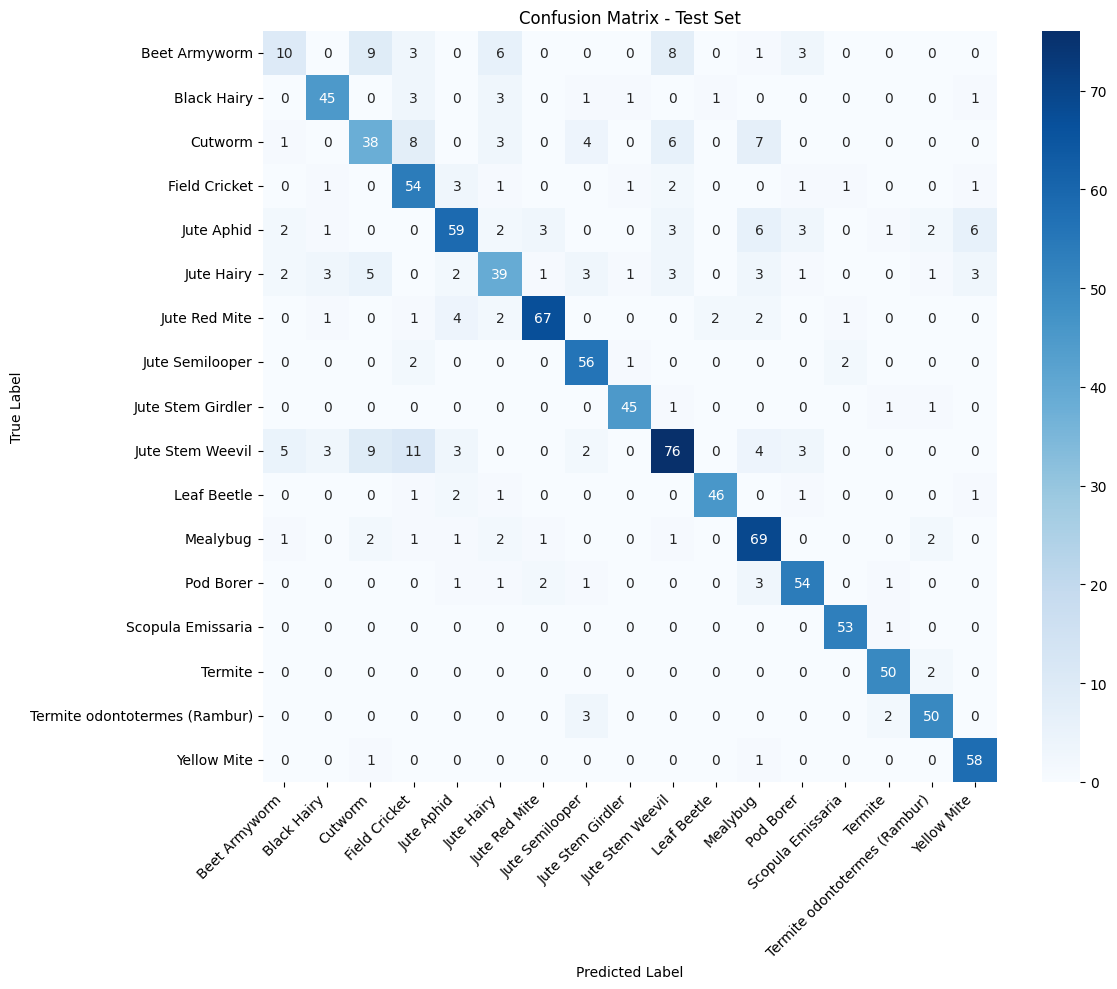

Classification Report - Test Set:
                               precision    recall  f1-score   support

                Beet Armyworm     0.4762    0.2500    0.3279        40
                  Black Hairy     0.8333    0.8182    0.8257        55
                      Cutworm     0.5938    0.5672    0.5802        67
                Field Cricket     0.6429    0.8308    0.7248        65
                   Jute Aphid     0.7867    0.6705    0.7239        88
                   Jute Hairy     0.6500    0.5821    0.6142        67
                Jute Red Mite     0.9054    0.8375    0.8701        80
              Jute Semilooper     0.8000    0.9180    0.8550        61
            Jute Stem Girdler     0.9184    0.9375    0.9278        48
             Jute Stem Weevil     0.7600    0.6552    0.7037       116
                  Leaf Beetle     0.9388    0.8846    0.9109        52
                     Mealybug     0.7188    0.8625    0.7841        80
                    Pod Borer     0.8182  

In [13]:
# Evaluate on UNSEEN test data
print("=== FINAL MODEL EVALUATION ON TEST SET ===")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"TEST Accuracy: {test_accuracy:.4f}")
print(f"TEST Loss: {test_loss:.4f}")

# Also get training accuracy for comparison
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"TRAIN Accuracy: {train_accuracy:.4f}")

# Get predictions for confusion matrix and metrics
y_true = []
y_pred = []

print("Generating predictions for test set...")
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Precision, Recall, F1-Score
print("Classification Report - Test Set:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names, digits=4))